In [1]:
from matplotlib.patches import Polygon as MplPolygon
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

from time import time

import numpy as np 
np.random.seed(1234)

import tensorflow as tf
tf.random.set_seed(1234)

import gpflow
gpflow.config.set_default_float(np.float32)
gpflow.config.set_default_jitter(1e-2)

from sgptools.methods import *
from sgptools.kernels import get_kernel
from sgptools.utils.tsp import *
from sgptools.utils.misc import *
from sgptools.utils.metrics import *
from sgptools.utils.data import Dataset
from sgptools.utils.gpflow import get_model_params

2026-01-08 11:14:50.834063: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 11:14:50.864549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767892490.899267    7412 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767892490.909975    7412 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767892490.938124    7412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def get_grid(X_data, num_x, num_y):
    grid_x, grid_y = np.mgrid[min(X_data[:, 0]):max(X_data[:, 0]):complex(num_x), 
                              min(X_data[:, 1]):max(X_data[:, 1]):complex(num_y)]
    X_grid = np.stack([grid_x, grid_y], axis=-1)
    return X_grid.reshape(-1, 2).astype(X_data.dtype)

In [3]:
# Load data
num_initial = 350
data = np.load("N17E073.npy")

# Get dataset
dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000)
del data
X_train, y_train = dataset.get_train()

# Generate X_init
X_init = get_inducing_pts(X_train, num_inducing=15)
X_init, _ = run_tsp(X_init)
X_init = X_init[0]
X_init = resample_path(X_init, num_initial)
X_init = X_init.astype(X_train.dtype)
X_init, y_init = dataset.get_sensor_data(X_init,
                                         max_samples=len(X_init))
print("Init Set Dims:", X_init.shape)

# Generate X_test
x_dim, y_dim = 100, 100
X_grid = get_grid(X_train, x_dim, y_dim)
X_grid, y_grid = dataset.get_sensor_data(X_grid,
                                         max_samples=len(X_grid))
print("Grid Set Dims:", X_grid.shape)

# Get the extent for potting
extent = [min(X_train[:, 0]), max(X_train[:, 0]), 
          min(X_train[:, 1]), max(X_train[:, 1])]

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (2500, 2), (2500, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.
Init Set Dims: (350, 2)
Grid Set Dims: (10000, 2)


2026-01-08 11:15:05.721010: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


╒═════════════════════════════╤══════════════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤═══════════════════════════════════════════╕
│ name                        │ class            │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                     │
╞═════════════════════════════╪══════════════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪═══════════════════════════════════════════╡
│ SGPR.kernel._free_amplitude │ ResourceVariable │                  │         │ True        │ ()       │ float32 │ 0.62927735                                │
├─────────────────────────────┼──────────────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────────┤
│ SGPR.kernel.lengthscales    │ ResourceVariable │                  │         │ False       │ (10,)    │ float32 │ [1., 2., 3....                            │
├─────────────────────────────┼───────────────

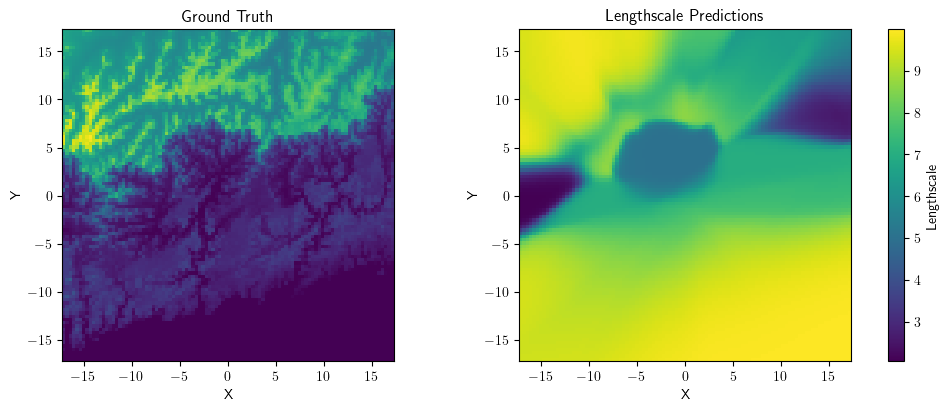

In [4]:
# Get lengthscales
_, noise_variance, kernel = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(np.linspace(1, 10, 10)),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    verbose=True)
ls_grid = kernel.get_lengthscales(X_grid)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(y_grid.reshape(x_dim, y_dim).T,
                     extent=extent, origin="lower")
axes[0].set_title("Ground Truth")
axes[0].set_aspect('equal')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Second subplot — test data
sc2 = axes[1].imshow(ls_grid.reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower")
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

In [5]:
kernel = 'Attentive'

if kernel == 'Attentive':
    _, noise_variance, kernel, init_model = get_model_params(
        X_train=X_init, y_train=y_init, 
        kernel=get_kernel('Attentive')(np.linspace(1, 10, 10)),
        optimizer='tf.Nadam',
        learning_rate=1e-2,
        max_steps=1000,
        return_model=True,
        verbose=True)
else:
    _, noise_variance, kernel, init_model = get_model_params(
        X_train=X_init, y_train=y_init, 
        kernel=get_kernel('RBF')(),
        return_model=True,
        verbose=True)

max_prior_var = init_model.predict_f(X_grid)[1].numpy().max()

╒════════════════════════════╤══════════════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name                       │ class            │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                                 │
╞════════════════════════════╪══════════════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪═══════════════════════════════════════════════════════╡
│ GPR.kernel._free_amplitude │ ResourceVariable │                  │         │ True        │ ()       │ float32 │ 0.93824726                                            │
├────────────────────────────┼──────────────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────────────────────┤
│ GPR.kernel.lengthscales    │ ResourceVariable │                  │         │ False       │ (10,)    │ float32 │ [1., 2., 3....                      

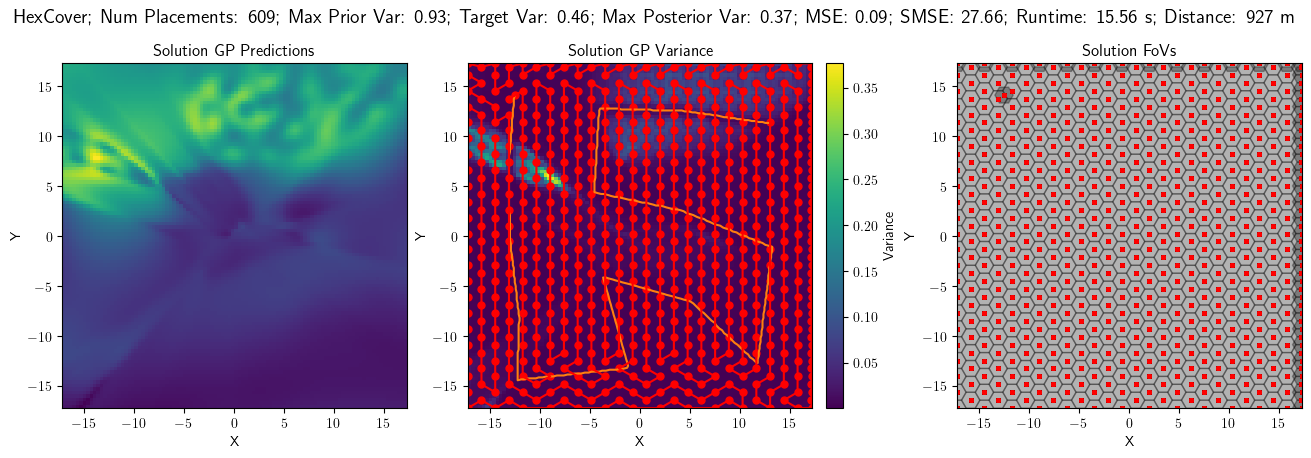

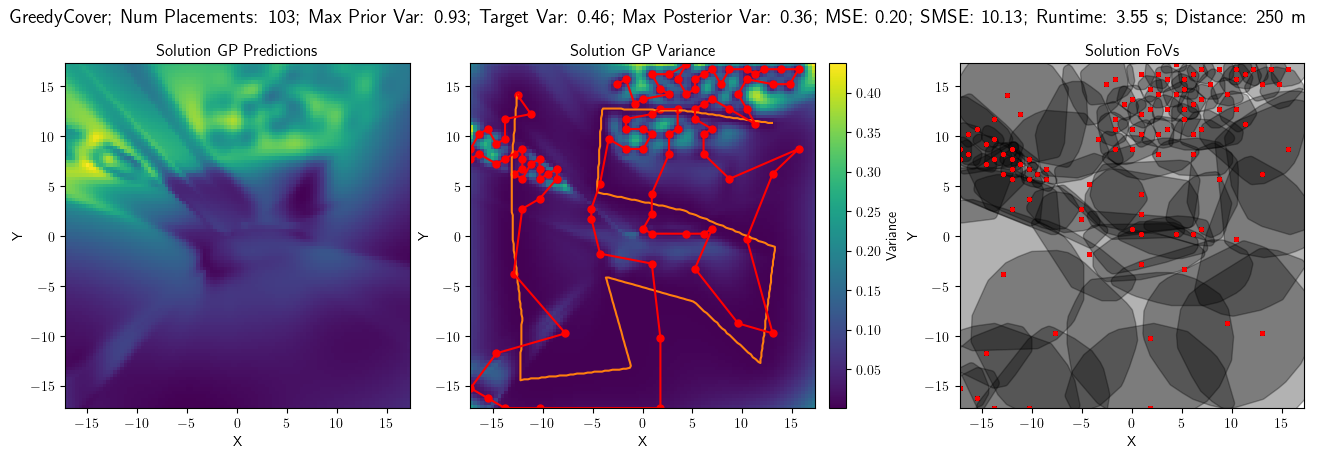

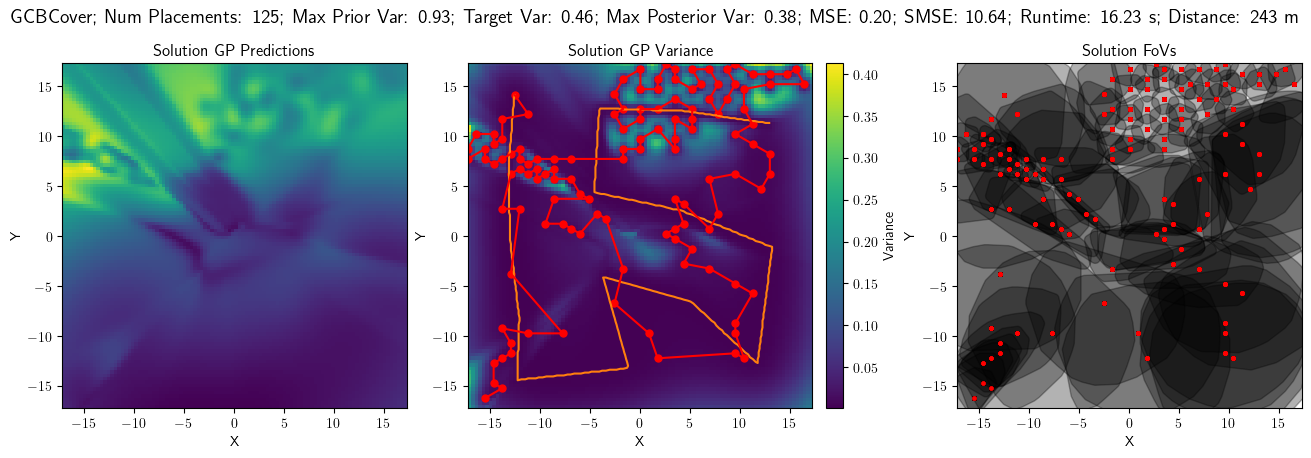

In [8]:
target_var_ratio = 0.5
var_threshold = max_prior_var * target_var_ratio

for method in ['HexCover', 'GreedyCover', 'GCBCover']:
    cmodel = get_method(method)(num_sensing=len(X_train),
                                X_objective=X_train,
                                kernel=kernel,
                                noise_variance=noise_variance)

    s_time = time()
    X_sol, fovs = cmodel.optimize(post_var_threshold=var_threshold, 
                                  return_fovs=True,
                                  start_nodes=X_init[None, -1])
    X_sol = X_sol[0]
    run_time = time()-s_time

    X_pred, y_pred = dataset.get_sensor_data(X_sol,
                                             max_samples=len(X_sol))
    _, _, _, model_sol = get_model_params(
        X_train=np.vstack([X_init, X_pred]), 
        y_train=np.vstack([y_init, y_pred]), 
        kernel=kernel,
        noise_variance=noise_variance,
        max_steps=0,
        return_model=True,
        verbose=False,
        force_gp=True)
    mean, var = model_sol.predict_f(X_grid)
    distance = get_distance(X_sol)
    mse_e = get_mse(mean.numpy(), y_grid)
    smse_e = get_smse(mean.numpy(), y_grid, var.numpy())
    max_post_var = model_sol.predict_f(X_train)[1].numpy().max()

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 4.5), constrained_layout=True)

    # First subplot — training data
    sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, 
                         extent=extent, origin="lower")
    axes[0].set_title("Solution GP Predictions")
    axes[0].set_aspect('equal')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    # Second subplot — Variance data
    sc2 = axes[1].imshow(var.numpy().reshape(x_dim, y_dim).T, 
                        extent=extent, origin="lower")
    axes[1].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=25)
    axes[1].plot(X_init[:, 0], X_init[:, 1], c='tab:orange')
    axes[1].plot(X_sol[:, 0], X_sol[:, 1], c='r')
    axes[1].set_title("Solution GP Variance")
    axes[1].set_aspect('equal')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')
    fig.colorbar(sc2, ax=axes[1], orientation='vertical', 
                fraction=0.05, pad=0.04, label='Variance')

    # Third subplot — FoV data
    axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
    for fov in fovs:
        patch = MplPolygon(list(fov.exterior.coords), 
                        closed=True, 
                        facecolor='k', 
                        edgecolor='k', 
                        alpha=0.3)
        axes[2].add_patch(patch)
        axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
    axes[2].set_title("Solution FoVs")
    axes[2].set_aspect('equal')
    axes[2].set_xlabel('X')
    axes[2].set_ylabel('Y')
    axes[2].set_xlim(axes[1].get_xlim())
    axes[2].set_ylim(axes[1].get_ylim())
    
    fig.suptitle(f"{method}; Num Placements: {len(fovs)}; Max Prior Var: {max_prior_var:.2f}; Target Var: {var_threshold:.2f}; Max Posterior Var: {max_post_var:.2f}; MSE: {mse_e:.2f}; SMSE: {smse_e:.2f}; Runtime: {run_time:.2f} s; Distance: {distance:.0f} m", fontsize=14)
    plt.show()